In [1]:
%pip install torch torchvision segmentation-models-pytorch matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as TF
from torchvision.transforms import ToPILImage
import segmentation_models_pytorch as smp
to_pil = ToPILImage()


In [3]:
class RooftopDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        base_name = os.path.splitext(image_name)[0]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, base_name + ".tif")

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        mask = (mask > 0).float()  # Ensure binary and float
        return image, mask   # Add channel dim to mask


In [4]:
transform_img = TF.Compose([
    TF.Resize((256, 256)),
    TF.ToTensor(),
    TF.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

transform_mask = TF.Compose([
    TF.Resize((256, 256)),
    TF.ToTensor(),  # Will produce shape [1, H, W]
])


In [5]:
image_dir = r"D:\Scarlet_Hawks\chicago_rooftops\kaggle_rooftop\images"
mask_dir = r"D:\Scarlet_Hawks\chicago_rooftops\kaggle_rooftop\labels"

dataset = RooftopDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform_img=transform_img,
    transform_mask=transform_mask
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [6]:
class RooftopSegmentationModel(nn.Module):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", classes=1):
        super().__init__()
        self.model = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, classes=classes, activation=None)

    def forward(self, x, overlay=False):
        logits = self.model(x)
        if overlay:
            preds = torch.sigmoid(logits) > 0.5
            overlays = []
            for i in range(x.size(0)):
                # Use the to_pil function defined outside the class
                image = to_pil((x[i].cpu() * 0.5 + 0.5).clamp(0, 1))
                mask_tensor = preds[i].cpu().squeeze(0).to(torch.uint8) * 255
                mask = to_pil(mask_tensor)  # Use the to_pil function here as well
                orange = Image.new("RGB", mask.size, (255, 165, 0))
                mask_colored = Image.composite(orange, image, mask)
                blended = Image.blend(image, mask_colored, alpha=0.5)
                overlays.append(blended)
            return overlays
        return logits

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RooftopSegmentationModel().to(device)


In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [9]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(loader):.4f}")


Epoch 1/5 - Loss: 0.3704
Epoch 2/5 - Loss: 0.2284
Epoch 3/5 - Loss: 0.1698
Epoch 4/5 - Loss: 0.1409
Epoch 5/5 - Loss: 0.1160


In [10]:
# Define image transformation (same as training)
transform = TF.Compose([
    TF.Resize((256, 256)),
    TF.ToTensor(),
    TF.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

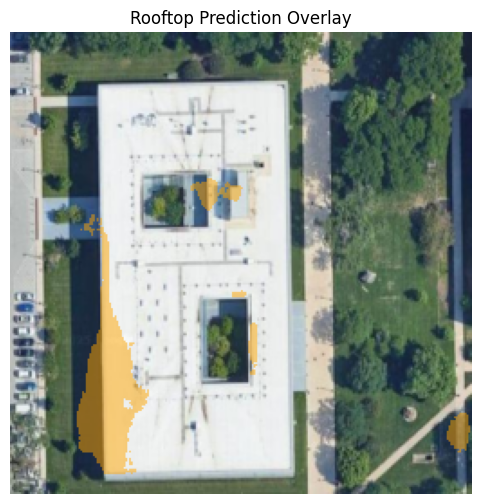

In [11]:
# Load and transform the input image
image_path = r"D:\Scarlet_Hawks\WhatsApp Image 2025-04-06 at 02.04.20_a9ee5c7b.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Predict with overlay
model.eval()
with torch.no_grad():
    overlay_result = model(input_tensor, overlay=True)[0]  # Only one image

# Show the result
plt.figure(figsize=(6, 6))
plt.imshow(overlay_result)
plt.axis("off")
plt.title("Rooftop Prediction Overlay")
plt.show()

In [12]:
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved as 'unet_model.pth'")


Model saved as 'unet_model.pth'


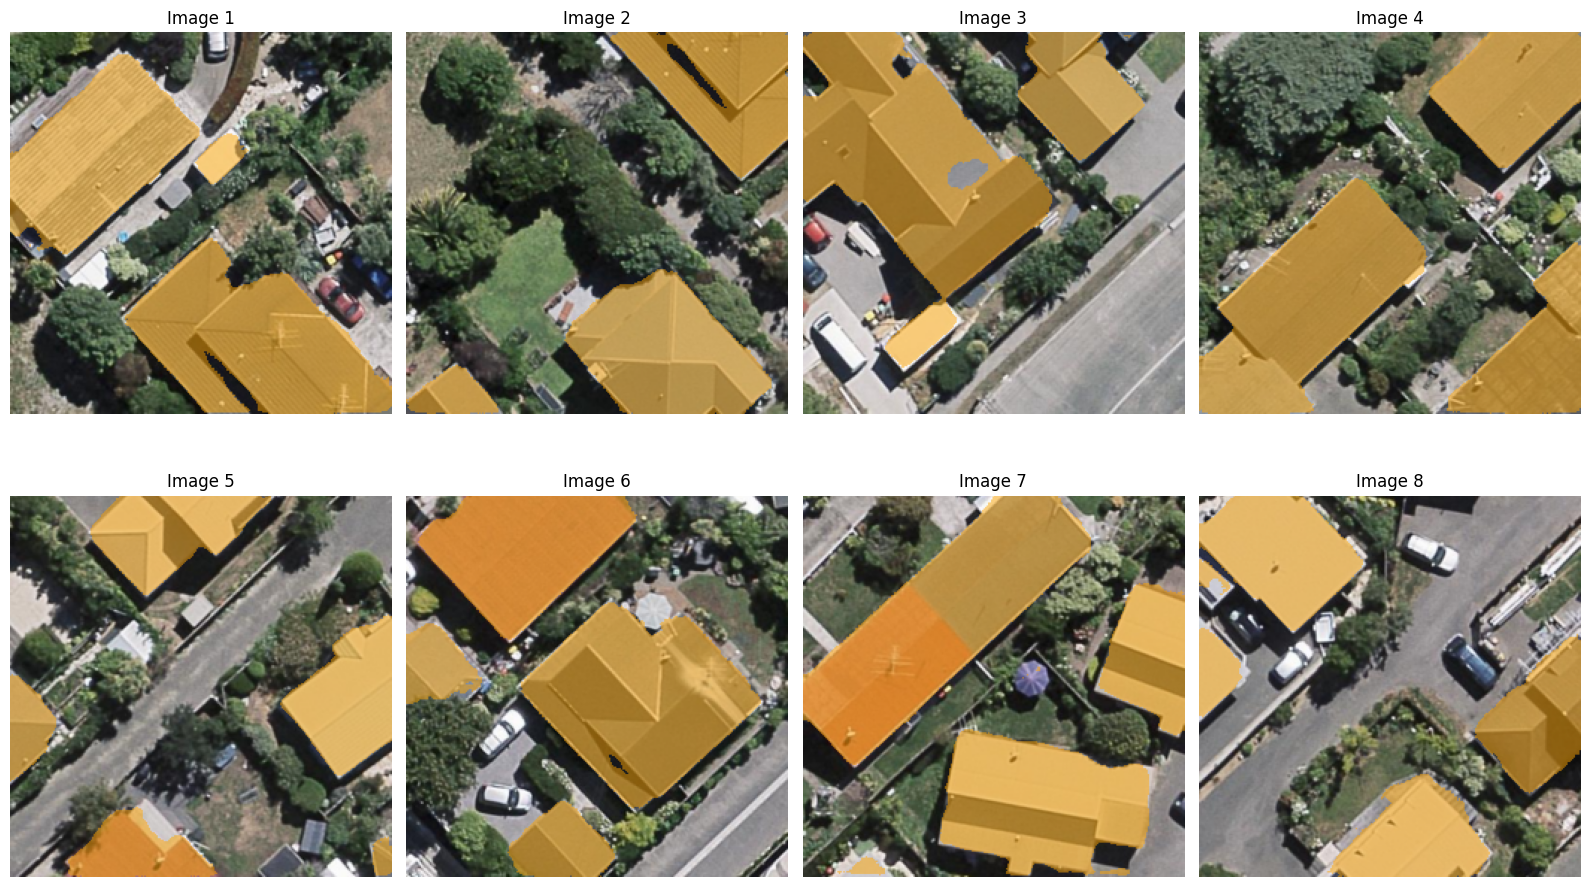

In [13]:

image_dir = r"D:\Scarlet_Hawks\chicago_rooftops\updates_output"  

image_files = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.jpg', '.png','.tif'))
])[:8]

# Load and transform images
images = []
for path in image_files:
    try:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img)
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Check and stack if not empty
if images:
    batch_tensor = torch.stack(images).to(device)

    # Predict with overlay
    model.eval()
    with torch.no_grad():
        overlay_results = model(batch_tensor, overlay=True)

    # Display results
    plt.figure(figsize=(16, 10))
    for i, overlay in enumerate(overlay_results):
        plt.subplot(2, 4, i+1)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()
else:
    print("No valid images found. Check the directory path and file extensions.")
